In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from sympy import *
from sympy.physics.quantum.dagger import Dagger

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import axes3d
from sympy import *
from sympy.physics.quantum.dagger import Dagger
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [9]:
def trace(M):
    return M[0,0] + M[1,1] + M[2,2] + M[3,3]

In [10]:
t,p,ta,pa = symbols('theta phi theta_a phi_a', real=True)

In [4]:
GA = Matrix([[cos(p/2)**2, I*cos(p/2)*sin(p/2), cos(p/2), 0],[-I*cos(p/2)*sin(p/2), sin(p/2)**2, -I*sin(p/2),0],
            [cos(p/2),I*sin(p/2),1,0],[0,0,0,0]])
GB = Matrix([[cos(p/2)**2, I*cos(p/2)*sin(p/2), 0, 0],[-I*cos(p/2)*sin(p/2), sin(p/2)**2, 0,0],
            [0,0,1,0],[0,0,0,0]])
AP = Matrix([[cos(ta/2),0,sin(ta/2),0],[0,cos(ta/2),0,sin(ta/2)],[sin(ta/2),0,-cos(ta/2),0],
              [0,sin(ta/2),0,-cos(ta/2)]])
AR = Matrix([[cos(pa/2),I*sin(pa/2),0,0],[I*sin(pa/2),cos(pa/2),0,0],[0,0,cos(pa/2),I*sin(pa/2)],
             [0,0,I*sin(pa/2),cos(pa/2)]])
AR_PS = Matrix([[cos(pa/2),I*sin(pa/2),0,0],[I*sin(pa/2),cos(pa/2),0,0],[0,0,1,0],
             [0,0,0,1]]) 
GoutA = conjugate(AR)*conjugate(AP)*GA*AP.T*AR.T
GoutB = conjugate(AR)*conjugate(AP)*GB*AP.T*AR.T

In [15]:
trigsimp(GB)

Matrix([
[cos(phi/2)**2,  I*sin(phi)/2, 0, 0],
[-I*sin(phi)/2, sin(phi/2)**2, 0, 0],
[            0,             0, 1, 0],
[            0,             0, 0, 0]])

In [11]:
trigsimp(GoutA-GoutB)

Matrix([
[                                                 2*sin(theta_a/2)*cos(phi_a/2)*cos(theta_a/2)*cos((phi + phi_a)/2),                                                  I*(cos(phi/2 + phi_a - theta_a) - cos(phi/2 + phi_a + theta_a))/4, -cos(phi/2 - theta_a)/4 - cos(phi/2 + theta_a)/4 - cos(phi/2 + phi_a - theta_a)/4 - cos(phi/2 + phi_a + theta_a)/4,                                   I*(2*sin(phi/2) - sin(phi/2 + phi_a - theta_a) - sin(phi/2 + phi_a + theta_a))/4],
[                                                I*(-cos(phi/2 + phi_a - theta_a) + cos(phi/2 + phi_a + theta_a))/4,                                                  2*sin(phi_a/2)*sin(theta_a/2)*sin((phi + phi_a)/2)*cos(theta_a/2),                                   I*(2*sin(phi/2) + sin(phi/2 + phi_a - theta_a) + sin(phi/2 + phi_a + theta_a))/4, -cos(phi/2 - theta_a)/4 - cos(phi/2 + theta_a)/4 + cos(phi/2 + phi_a - theta_a)/4 + cos(phi/2 + phi_a + theta_a)/4],
[-cos(phi/2 - theta_a)/4 - cos(phi/2 + theta_a)/4 - cos(phi

In [16]:
Gout=GoutA

In [17]:
C_ta_pa = trigsimp((Gout[0,0]-Gout[1,1]-Gout[2,2]+Gout[3,3])/(Gout[0,0]+Gout[1,1]+Gout[2,2]+Gout[3,3]))
C_ta_pa

sin(theta_a)*cos(phi/2 + phi_a) - cos(phi_a)*cos(theta_a)/2 + cos(theta_a)*cos(phi + phi_a)/2

In [18]:
Expected = sin(p/2)*sin(ta-pa-p/2) - (1-sin(p/2))*cos(pa+p/2)*sin(ta)
trigsimp(Expected-C_ta_pa)

sin(phi/2 + phi_a - theta_a) - sin(phi/2 + phi_a + theta_a) - cos(phi_a - theta_a)/2 + cos(phi_a + theta_a)/2 + cos(phi + phi_a - theta_a)/2 - cos(phi + phi_a + theta_a)/2

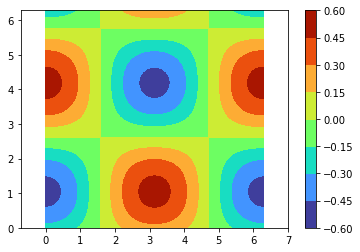

In [26]:
f = lambdify((t,p,ta,pa),Expected, "numpy")
ta_range = np.linspace(0,2*np.pi,1000);
pa_range = np.linspace(0,2*np.pi,1000);
phi_fixed = np.pi/3;
X, Y = np.meshgrid(ta_range, pa_range);
def ftemp(ta_val,pa_val):
    return f(0,phi_fixed,ta_val,pa_val);
Z = ftemp(X,Y);
fig,ax=plt.subplots(1,1);
cp = ax.contourf(X, Y, Z, cmap='turbo');
fig.colorbar(cp) # Add a colorbar to a plot
plt.xlim(0,2*np.pi);
plt.ylim(0,2*np.pi);
ax.axis('equal');

In [ ]:
G_input = Matrix([1,0,1,0])*Matrix([1,0,1,0]).T
a = conjugate(AR_PS)*G_input*AR_PS.T

In [ ]:
a

In [ ]:
trigsimp(trace(a*a) - 1)*1/3

# BLANK

# BLANK

In [39]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

In [78]:
def contourplotter(function,phi,title,xlabel,ylabel):
    f = lambdify((t,p,ta,pa),function, "numpy")
    ta_range = np.linspace(0,2*np.pi,1000);
    pa_range = np.linspace(0,2*np.pi,1000);
    phi_fixed = phi;
    X, Y = np.meshgrid(ta_range, pa_range);
    def ftemp(ta_val,pa_val):
        return f(0,phi_fixed,ta_val,pa_val);
    Z = ftemp(X,Y);
    fig, ax = plt.subplots(figsize=(7,5.7))
    cp = ax.contourf(X, Y, Z ,cmap='turbo');
    fig.colorbar(cp) # Add a colorbar to a plot
    plt.xlim(0,2*np.pi);
    plt.ylim(0,2*np.pi);
    ax.axis('equal');

    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    ax=plt.gca()
    ax.set_facecolor((0.8,1,1))
    ax.axhline(0, color='black', lw=2)
    ax.axvline(0, color='black', lw=2)
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    plt.xticks(fontsize =15)
    plt.yticks(fontsize =15)
    return

In [79]:
def expAContours(phi):
    function=C_ta_pa
    contourplotter(function,phi,'a','b','c')
    return
interact(expAContours, phi=widgets.FloatSlider(min=0, max=2*np.pi, step=0.01, value=np.pi/3, continuous_update=False));

interactive(children=(FloatSlider(value=1.0471975511965976, continuous_update=False, description='phi', max=6.…

In [76]:
def expAContours(phi):
    function=Expected
    contourplotter(function,phi,'a','b','c')
    return
interact(expAContours, phi=widgets.FloatSlider(min=0, max=2*np.pi, step=0.01, value=np.pi/3, continuous_update=False));

interactive(children=(FloatSlider(value=1.0471975511965976, continuous_update=False, description='phi', max=6.…